In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


%matplotlib inline

'''
Класс, представляющий собой одну кинематическую пару
'''
class KinematicPart:
    s = tf.constant(0, dtype=tf.float32)
    a = tf.constant(0, dtype=tf.float32)
    alpha = tf.constant(0, dtype=tf.float32)
    
    borderMin = tf.constant(0, dtype=tf.float32)
    borderMax = tf.constant(0, dtype=tf.float32)
    
    def __init__(self, s,a,alpha, bmin, bmax):
        self.s = tf.constant(s, dtype=tf.float32)
        self.a = tf.constant(a, dtype=tf.float32)
        self.alpha = tf.constant(alpha, dtype=tf.float32)
        self.borderMin = tf.constant(bmin, dtype=tf.float32)
        self.borderMax = tf.constant(bmax, dtype=tf.float32)
        
    def getMatrix(self, q):
        return [
            [tf.cos(q), -tf.sin(q)*tf.cos(self.alpha), tf.sin(q)*tf.sin(self.alpha), self.a*tf.cos(q)],
            [tf.sin(q), tf.cos(q)*tf.cos(self.alpha), -tf.cos(q)*tf.sin(self.alpha), self.a*tf.sin(q)],
            [0, tf.sin(self.alpha), tf.cos(self.alpha), self.s],
            [0, 0, 0, 1]
                         ]


'''
Класс робота, состоящего из пар
'''
class Robot:
    parts = []
    penaltiesMin = None
    penaltiesMax = None
    
    def __init__(self, parts):
        self.parts = parts
        self.penaltiesMin = [(p.borderMin) for p in self.parts]
        self.penaltiesMax = [(p.borderMax) for p in self.parts]
    
    '''
    Получить значение штрафа для данных обобщенных координат
    '''
    def penalty(self, Q, W1=1, W2=1):
        
        reduce_to_nil = lambda n: tf.cond(n > 0,
                                         lambda:tf.constant(0,dtype=tf.float32), lambda:tf.abs(n))
        
        return W1*tf.reduce_sum(
            tf.map_fn(reduce_to_nil, tf.subtract(Q, self.penaltiesMin))
        ) + W2*tf.reduce_sum(tf.map_fn(reduce_to_nil, tf.subtract(self.penaltiesMax, Q)))
    
    
    '''
    Получить координаты схвата (конечного звена)
    '''
    def getXYZ(self, Q):
        return self.getXYZPair(Q, len(self.parts))
    
    '''
    Получить координаты конкретной пары 
    '''    
    def getXYZPair(self, Q, pair):
        
        resultMatrix = tf.eye(4, dtype=tf.float32)
        
        for i,p in enumerate(self.parts):
            
            if i==pair:
                break
            
            resultMatrix = tf.matmul(resultMatrix,p.getMatrix(Q[i]))
        
        xyz1 = tf.matmul(resultMatrix,tf.constant([[0],[0],[0],[1]], dtype=tf.float32))
        #res = np.squeeze(xyz1,[3])
        return xyz1
    
    
    '''
    Массив координат всех пар (для построения графика)
    '''
    def getPairPoints(self, Q):
        
        result = []
        
        for i,p in enumerate(self.parts):
            pairXYZ = self.getXYZPair(Q,i)
            result.append([pairXYZ[0],pairXYZ[1], pairXYZ[2]])
        
        return result


In [2]:
r=np.pi/180.0;
Z1 = KinematicPart(300, 0, np.pi/2, bmin=-150*r, bmax=150*r)
Z2 = KinematicPart(0, 250, 0, bmin=-30*r, bmax=150*r)
Z3 = KinematicPart(0, 160, 0, bmin=-150*r, bmax=80*r)
Z4 = KinematicPart(0, 0, np.pi/2, bmin=-150*r, bmax=80*r)
Z5 = KinematicPart(0, 72, 0, bmin=0*r, bmax=0*r)

parts = [Z1,Z2,Z3,Z4,Z5]

RV = Robot(parts)

# Q = tf.Variable([  20,   22*r,   16*r,
#         20*r], dtype=tf.float32)

# xyz = kuka.getXYZ(Q)[:3]

In [54]:
Q0 = tf.Variable([  20*r,   20*r,  20*r, 20*r, 0],dtype=tf.float32)
#Q0 = tf.Variable([-0.00081764*r,  0.38168061*r,  0.29301527*r,  0.34906584*r],dtype=tf.float32)

target = tf.constant([[200],[48],[350]], dtype=tf.float32)

xyz = RV.getXYZ(Q0)[:3]
penalty = RV.penalty(Q0, 9999, 9999)

loss = tf.reduce_sum(tf.sqrt(tf.pow(target-xyz, 2))) + penalty

global_step = tf.Variable(0.0, trainable=False)

epoch = tf.Variable(1, trainable=True, dtype=tf.int32)

new_epoch = tf.assign(epoch, epoch+1)

initial_learning_rate = 0.25
starter_learning_rate = tf.train.exponential_decay(initial_learning_rate, epoch,
                                           1, 0.95, staircase=False)

learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                          10, 0.96, staircase=False)



optimizer = tf.train.AdamOptimizer(learning_rate)
grad = optimizer.compute_gradients(loss, [Q0])


best_loss = tf.Variable(tf.float32.max, dtype=tf.float32)
best_q = tf.Variable([0,0,0,0,0], dtype=tf.float32)

assign_best_loss = tf.assign(best_loss,
                             tf.cond(best_loss>loss, lambda:loss, lambda:best_loss))

assign_best_q = tf.assign(best_q,
                          tf.cond(best_loss>loss, lambda:Q0, lambda:best_q))

new_best_loss = [assign_best_q, assign_best_loss]

error_decay = loss - best_loss

gradRV = tf.concat([
    tf.reshape(tf.slice(grad, [0,0,0], [1,1,4]),[4]), 
    [0]],0)

cn = tf.is_nan(grad[0][0])

grad_and_vars = [(tf.cond(tf.equal(cn[0],tf.constant(False)), 
                                  lambda:gradRV,
                                  lambda:tf.constant([1, 1, 1, 1, 0], dtype=tf.float32)
                                 ), grad[0][1])]


train = optimizer.apply_gradients(grad_and_vars,global_step=global_step)


reset_step = tf.variables_initializer([global_step])

model = tf.global_variables_initializer()


starting at Q: [ 0.34906584  0.34906584  0.34906584  0.34906584  0.        ] loss: 3.40282e+38
Steps 1903.0
bestQ: 13.493*r, 55.621*r, -98.113*r, -95.424*r, 0.000*r  bestLoss:  0.0341606


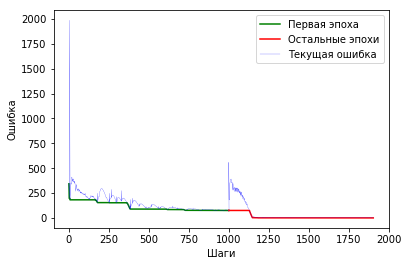

Wall time: 26.1 s


In [57]:
%%time

STEPS_IN_EPOCH = 1000
MAX_EPOCHS = 2
DECAY_PRECISION = 0.0009

traceX = []
traceY = []
traceLoss = []
with tf.Session() as session:
    session.run(model)
    print("starting at", "Q:", session.run(Q0), "loss:", session.run(best_loss))
    while session.run(best_loss) >= 0.04:
        step = session.run(global_step)
        e = session.run(epoch)
        curStep=step+STEPS_IN_EPOCH*(e-1)
        session.run(train)
        decay = session.run(error_decay)
        session.run(new_best_loss)
          
        if step > STEPS_IN_EPOCH:
            if session.run(epoch) >= MAX_EPOCHS:
                break
            
            session.run(new_epoch)
            session.run(reset_step)
        
        traceX.append(curStep)
        traceY.append(session.run(best_loss))
        traceLoss.append(session.run(loss))
#         if(step % 50 == 0):
#             print("epoch", session.run(epoch), "step", curStep, "decay:", decay, "loss:",
#                   session.run(best_loss), "penalty: ", session.run(penalty))
    
    print("Steps",curStep)
    print("bestQ: %.3f*r, %.3f*r, %.3f*r, %.3f*r, %.3f*r"% tuple(session.run(best_q)/r), " bestLoss: ", session.run(best_loss))
    mpl.rcParams['legend.fontsize'] = 10

    fig = plt.figure()
    ax = fig.gca()
    
    ax.plot(traceX[:STEPS_IN_EPOCH], traceY[:STEPS_IN_EPOCH], color="green")
    ax.plot(traceX[STEPS_IN_EPOCH:], traceY[STEPS_IN_EPOCH:], color="red")
    ax.plot(traceX,traceLoss, color="blue", lw=0.2)

    ax.set_xlabel("Шаги")
    ax.set_ylabel("Ошибка")
    ax.legend(["Первая эпоха", "Остальные эпохи", "Текущая ошибка"])

    plt.show()

In [ ]:
 plt.plot(traceX,traceY)